#### Library import

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from ngboost import NGBRegressor
from scipy.stats import norm, skew

from matplotlib.ticker import FormatStrFormatter

from tensorflow import keras

import re
from tqdm import tqdm

#### GPU setting

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [3]:
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = InteractiveSession(config = config)

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 846070126142094540
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3435973836
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5382535062879019993
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6"
]


In [5]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

#### Data import and preprocessing

In [6]:
data = pd.read_csv("data/data_kw.csv")
data.columns

Index(['OBJECTID_x', 'ID', 'pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope',
       'altitude', 'profile_curve', 'profile_c_num', 'profile_c_abs',
       'planform_curve', 'planform_c_num', 'planform_c_abs', 'HYDGRP',
       'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C', 'HYDGRP_D', 'ANION_EXCL', 'SOL_CRK',
       'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'SOL_EC1', 'distance'],
      dtype='object')

In [7]:
data = data.drop(['OBJECTID_x','ID','HYDGRP','profile_c_num', 'profile_c_abs','planform_c_num', 'planform_c_abs','ANION_EXCL','SOL_CRK','SOL_EC1'], axis = 1)
data.columns

Index(['pH', 'As', 'Cd', 'Ni', 'Pb', 'Zn', 'Hg', 'slope', 'altitude',
       'profile_curve', 'planform_curve', 'HYDGRP_A', 'HYDGRP_B', 'HYDGRP_C',
       'HYDGRP_D', 'SOL_K1', 'CLAY1', 'SILT1', 'SAND1', 'ROCK1', 'distance'],
      dtype='object')

In [8]:
As = data
Cd = data
Ni = data

In [9]:
As = As.drop(["Cd", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Cd = Cd.drop(["As", "Ni", "Pb", "Zn", "Hg"], axis = 1)
Ni = Ni.drop(["As", "Cd", "Pb", "Zn", "Hg"], axis = 1)

In [10]:
print(As.shape)
print(Cd.shape)
print(Ni.shape)

(677, 16)
(677, 16)
(677, 16)


#### Oversampling by SMOGN (SMOTE Regression)

In [11]:
import smogn

In [12]:
As_smogn = smogn.smoter(data = As, y = 'As', samp_method = 'extreme')
Cd_smogn = smogn.smoter(data = Cd, y = 'Cd', samp_method = 'extreme')
Ni_smogn = smogn.smoter(data = Ni, y = 'Ni', samp_method = 'extreme')

dist_matrix:   0%|          | 0/134 [00:00<?, ?it/s]

r_index: 100%|##########| 38/38 [00:00<00:00, 643.94it/s]


In [13]:
print(As_smogn.shape)
print(Cd_smogn.shape)
print(Ni_smogn.shape)

(971, 16)
(887, 16)
(986, 16)


#### Eliminate outlier and train / test split

In [14]:
def eli_outlier(data, value):
    q1 = data[value].quantile(0.25)
    q3 = data[value].quantile(0.75)

    iqr = q3 - q1

    q1_condition = data[value] < q1-1.5*iqr
    q3_condition = data[value] > q3+1.5*iqr

    reset_q1_index = data[q1_condition].index
    reset_q3_index = data[q3_condition].index

    data.drop(reset_q1_index, inplace = True)
    data.drop(reset_q3_index, inplace = True)

    return data

In [15]:
As_ros = eli_outlier(As_smogn, "As")
Cd_ros = eli_outlier(Cd_smogn, "Cd")
Ni_ros = eli_outlier(Ni_smogn, "Ni")

In [16]:
As_X = As_ros.drop(["As"], axis=1)
Cd_X = Cd_ros.drop(["Cd"], axis=1)
Ni_X = Ni_ros.drop(["Ni"], axis=1)

As_y = As_ros["As"]
Cd_y = Cd_ros["Cd"]
Ni_y = Ni_ros["Ni"]

In [17]:
As_y = np.log1p(As_ros["As"])
Cd_y = np.log1p(Cd_ros["Cd"])
Ni_y = np.log1p(Ni_ros["Ni"])

In [18]:
print(As_X.shape)
print(Cd_X.shape)
print(Ni_X.shape)

(789, 15)
(748, 15)
(978, 15)


StandardScaler

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X, As_y, test_size=0.2, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X, Cd_y, test_size=0.2, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X, Ni_y, test_size=0.2, random_state=42)

As_X_train = scaler.fit_transform(As_X_train)
As_X_test = scaler.fit_transform(As_X_test)

Cd_X_train = scaler.fit_transform(Cd_X_train)
Cd_X_test = scaler.fit_transform(Cd_X_test)

Ni_X_train = scaler.fit_transform(Ni_X_train)
Ni_X_test = scaler.fit_transform(Ni_X_test)

In [20]:
''' from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
As_X_scaled = scaler.fit_transform(As_X)
Cd_X_scaled = scaler.fit_transform(Cd_X)
Ni_X_scaled = scaler.fit_transform(Ni_X)

As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42) '''

' from sklearn.preprocessing import StandardScaler\n\nscaler = StandardScaler()\nAs_X_scaled = scaler.fit_transform(As_X)\nCd_X_scaled = scaler.fit_transform(Cd_X)\nNi_X_scaled = scaler.fit_transform(Ni_X)\n\nAs_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)\nCd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)\nNi_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42) '

MinMaxScaler

In [21]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# As_X_scaled = scaler.fit_transform(As_X)
# Cd_X_scaled = scaler.fit_transform(Cd_X)
# Ni_X_scaled = scaler.fit_transform(Ni_X)

# As_X_train, As_X_test, As_y_train, As_y_test = train_test_split(As_X_scaled, As_y, test_size=0.2, random_state=42)
# Cd_X_train, Cd_X_test, Cd_y_train, Cd_y_test = train_test_split(Cd_X_scaled, Cd_y, test_size=0.2, random_state=42)
# Ni_X_train, Ni_X_test, Ni_y_train, Ni_y_test = train_test_split(Ni_X_scaled, Ni_y, test_size=0.2, random_state=42)

In [22]:
print(As_X_train.shape)
print(Cd_X_train.shape)
print(Ni_X_train.shape)

(631, 15)
(598, 15)
(782, 15)


#### 10-Fold Crossvalidation

In [23]:
# kf = KFold(n_splits = 10, random_state = 42, shuffle = True)

#### Optuna Optimization

In [24]:
import optuna

from optuna import Trial
from optuna.samplers import TPESampler

In [25]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVR


def objectiveSVM(trial: Trial, X_train, y_train) -> float:
    C = trial.suggest_loguniform('C', 0.1, 100.0)
    epsilon = trial.suggest_loguniform('epsilon', 0.01, 1.0)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    degree = trial.suggest_int('degree', 1, 5)
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    model = SVR(C=C, epsilon=epsilon, kernel=kernel, degree=degree)

    r2 = cross_val_score(model, X_train, y_train, scoring='r2', cv=kf)
    r2 = r2.mean()

    return r2


####  Optimization

In [26]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="svm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveSVM(trial, As_X_train, As_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-24 14:32:05,795] A new study created in memory with name: svm_parameter_opt
[I 2023-08-24 14:32:05,911] Trial 0 finished with value: 0.19654727415131465 and parameters: {'C': 0.5348982466951453, 'epsilon': 0.25290300817424244, 'kernel': 'linear', 'degree': 2}. Best is trial 0 with value: 0.19654727415131465.
[I 2023-08-24 14:32:08,600] Trial 1 finished with value: 0.19753401666972845 and parameters: {'C': 40.1437149059588, 'epsilon': 0.11421505705359312, 'kernel': 'linear', 'degree': 5}. Best is trial 1 with value: 0.19753401666972845.
[I 2023-08-24 14:32:08,778] Trial 2 finished with value: 0.017852796486908316 and parameters: {'C': 7.603552461254027, 'epsilon': 0.10519263518938808, 'kernel': 'poly', 'degree': 3}. Best is trial 1 with value: 0.19753401666972845.
[I 2023-08-24 14:32:09,081] Trial 3 finished with value: 0.1904502547328526 and parameters: {'C': 3.0465392053913467, 'epsilon': 0.0916402346210566, 'kernel': 'linear', 'degree': 3}. Best is trial 1 with value: 0.19

Best r2:  0.42034428710235233
Best trial: {'C': 4.89891238197303, 'epsilon': 0.36513313573545114, 'kernel': 'rbf', 'degree': 1}


In [27]:
optuna.visualization.plot_parallel_coordinate(study)

In [28]:
print("Best trial:", study.best_trial.params)

Best trial: {'C': 4.89891238197303, 'epsilon': 0.36513313573545114, 'kernel': 'rbf', 'degree': 1}


In [29]:
svm_params = {
    "C": study.best_trial.params["C"],
    "epsilon": study.best_trial.params["epsilon"],
    "kernel": study.best_trial.params["kernel"],
    "degree": study.best_trial.params["degree"]
}

svm = SVR(**svm_params)
svm.fit(As_X_train, As_y_train)

SVR(C=4.89891238197303, degree=1, epsilon=0.36513313573545114)

In [30]:
y_train_pred = svm.predict(As_X_train)
y_test_pred = svm.predict(As_X_test)

In [31]:
# plt.scatter(y_train_pred, np.array(As_y_train))

In [32]:
print("Train RMSE: ", np.sqrt(mean_squared_error(As_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(As_y_test, y_test_pred)))

Train RMSE:  0.537695646394691
Test RMSE:  0.6968090503004354


In [33]:
print("Train R2: ", r2_score(As_y_train, y_train_pred))
print("Test R2: ", r2_score(As_y_test, y_test_pred))

Train R2:  0.6442188562689908
Test R2:  0.39537009440556714


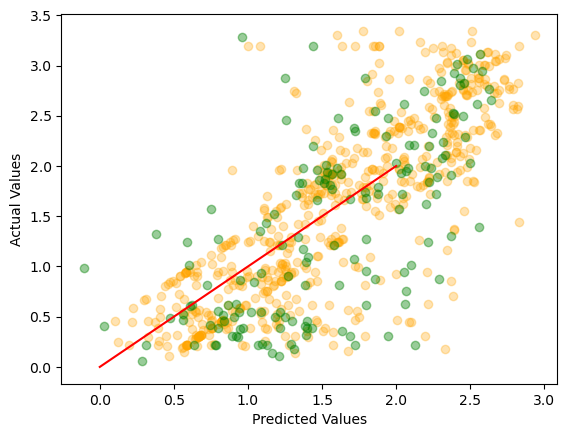

In [34]:
plt.scatter(y_train_pred, np.array(As_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(As_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 2.0], [0, 2.0], color='red', linestyle='-')

plt.show()

Cd

Optimization

In [35]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="svm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveSVM(trial, Cd_X_train, Cd_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-24 14:32:23,265] A new study created in memory with name: svm_parameter_opt
[I 2023-08-24 14:32:23,354] Trial 0 finished with value: -0.008298568081250046 and parameters: {'C': 0.19797311902252507, 'epsilon': 0.01973943152038071, 'kernel': 'poly', 'degree': 5}. Best is trial 0 with value: -0.008298568081250046.
[I 2023-08-24 14:32:23,529] Trial 1 finished with value: -0.5933177038023626 and parameters: {'C': 3.3271412163577607, 'epsilon': 0.03814654009251565, 'kernel': 'poly', 'degree': 5}. Best is trial 0 with value: -0.008298568081250046.
[I 2023-08-24 14:32:23,541] Trial 2 finished with value: -0.4072942131459957 and parameters: {'C': 0.9365163004727649, 'epsilon': 0.6455879462352787, 'kernel': 'poly', 'degree': 3}. Best is trial 0 with value: -0.008298568081250046.
[I 2023-08-24 14:32:23,632] Trial 3 finished with value: 0.18810937316044649 and parameters: {'C': 0.2426301781559355, 'epsilon': 0.01544596036043487, 'kernel': 'poly', 'degree': 4}. Best is trial 3 with value

Best r2:  0.46313796677106545
Best trial: {'C': 0.875182041375404, 'epsilon': 0.12362175625357873, 'kernel': 'rbf', 'degree': 3}


In [36]:
optuna.visualization.plot_parallel_coordinate(study)

In [37]:
print("Best trial:", study.best_trial.params)

Best trial: {'C': 0.875182041375404, 'epsilon': 0.12362175625357873, 'kernel': 'rbf', 'degree': 3}


In [38]:
svm_params = {
    "C": study.best_trial.params["C"],
    "epsilon": study.best_trial.params["epsilon"],
    "kernel": study.best_trial.params["kernel"],
    "degree": study.best_trial.params["degree"]
}

svm = SVR(**svm_params)
svm.fit(Cd_X_train, Cd_y_train)

SVR(C=0.875182041375404, epsilon=0.12362175625357873)

In [39]:
y_train_pred = svm.predict(Cd_X_train)
y_test_pred = svm.predict(Cd_X_test)

In [40]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Cd_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Cd_y_test, y_test_pred)))

Train RMSE:  0.1773264280292402
Test RMSE:  0.19878314732783406


In [41]:
print("Train R2: ", r2_score(Cd_y_train, y_train_pred))
print("Test R2: ", r2_score(Cd_y_test, y_test_pred))

Train R2:  0.629280187961132
Test R2:  0.5384936347680643


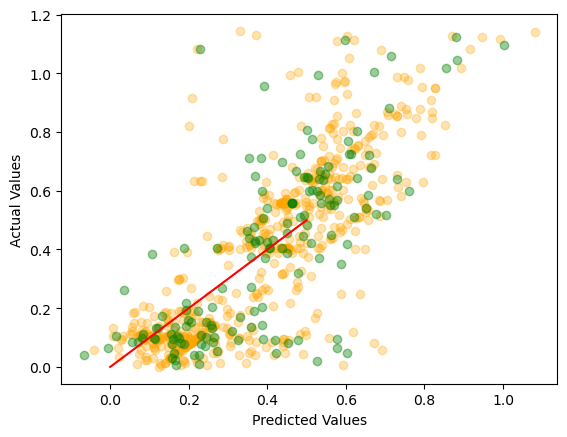

In [42]:
plt.scatter(y_train_pred, np.array(Cd_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Cd_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 0.5], [0, 0.5], color='red', linestyle='-')

plt.show()

Ni

In [43]:
sampler = TPESampler()
study = optuna.create_study(
    study_name="svm_parameter_opt",
    direction="maximize",
    sampler=sampler,
)

study.optimize(lambda trial : objectiveSVM(trial, Ni_X_train, Ni_y_train), n_trials=100)
print("Best r2: ", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-08-24 14:32:37,606] A new study created in memory with name: svm_parameter_opt
[I 2023-08-24 14:32:37,727] Trial 0 finished with value: 0.1353890492624346 and parameters: {'C': 0.11814258643209961, 'epsilon': 0.041069828554114306, 'kernel': 'linear', 'degree': 5}. Best is trial 0 with value: 0.1353890492624346.
[I 2023-08-24 14:32:37,859] Trial 1 finished with value: 0.14677684215736359 and parameters: {'C': 4.1055411181574994, 'epsilon': 0.09832650228147641, 'kernel': 'poly', 'degree': 1}. Best is trial 1 with value: 0.14677684215736359.
[I 2023-08-24 14:32:37,990] Trial 2 finished with value: 0.009378381268374735 and parameters: {'C': 0.4427124403585699, 'epsilon': 0.048363175210289704, 'kernel': 'poly', 'degree': 5}. Best is trial 1 with value: 0.14677684215736359.
[I 2023-08-24 14:32:38,077] Trial 3 finished with value: 0.4894996925631411 and parameters: {'C': 1.9028811745279688, 'epsilon': 0.6263856717162802, 'kernel': 'rbf', 'degree': 3}. Best is trial 3 with value: 0.489

Best r2:  0.5448356162575172
Best trial: {'C': 7.135690054282019, 'epsilon': 0.26668523510566133, 'kernel': 'rbf', 'degree': 4}


In [44]:
optuna.visualization.plot_parallel_coordinate(study)

In [45]:
print("Best trial:", study.best_trial.params)

Best trial: {'C': 7.135690054282019, 'epsilon': 0.26668523510566133, 'kernel': 'rbf', 'degree': 4}


In [46]:
svm_params = {
    "C": study.best_trial.params["C"],
    "epsilon": study.best_trial.params["epsilon"],
    "kernel": study.best_trial.params["kernel"],
    "degree": study.best_trial.params["degree"]
}

svm = SVR(**svm_params)
svm.fit(Ni_X_train, Ni_y_train)

SVR(C=7.135690054282019, degree=4, epsilon=0.26668523510566133)

In [47]:
y_train_pred = svm.predict(Ni_X_train)
y_test_pred = svm.predict(Ni_X_test)

In [48]:
print("Train RMSE: ", np.sqrt(mean_squared_error(Ni_y_train, y_train_pred)))
print("Test RMSE: ", np.sqrt(mean_squared_error(Ni_y_test, y_test_pred)))

Train RMSE:  0.599306691281773
Test RMSE:  0.7700191722899864


In [49]:
print("Train R2: ", r2_score(Ni_y_train, y_train_pred))
print("Test R2: ", r2_score(Ni_y_test, y_test_pred))

Train R2:  0.7527124582087972
Test R2:  0.5842670685122107


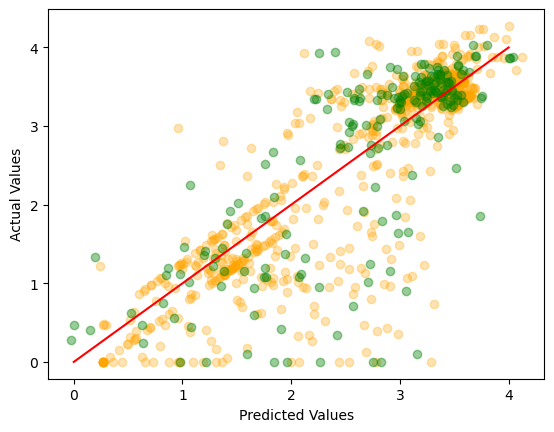

In [50]:
plt.scatter(y_train_pred, np.array(Ni_y_train), color="orange", alpha=0.3)
plt.scatter(y_test_pred, np.array(Ni_y_test), color="green", alpha=0.4)
plt.axis("auto") # scaled, tight, auto, image, square
# plt.xlim([0, 1.5]) 
# plt.ylim(0, None) 
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')

# Add y=x line
plt.plot([0, 4.0], [0, 4.0], color='red', linestyle='-')

plt.show()